In [1]:
import os
import sys
sys.path.append("../Processor")
import time
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()
from torch.utils.data import DataLoader
import torchvision
from optim import RAdam
from tqdm import tqdm_notebook as tqdm
from data_processor import SpeechDigitsDataset, BinningHistogram, Pad
from models import SNN, SpikingConv2DLayer, ReadoutLayer, SurrogateHeaviside, SpikingDenseLayer
from utils import plot_spk_rec, plot_mem_rec

In [2]:
dtype = torch.float16
device = torch.device("cuda:0")

In [3]:
label_dct = {'o': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'z': 0}

In [4]:
data_root = ""
binning_method = "time"
T_l = 0.005
E = 25

In [5]:
train_dataset_raw = SpeechDigitsDataset(data_root=data_root, mode="train", train_proportion=0.8, label_dct=label_dct, transform = None, nb_digits=1)
test_dataset_raw = SpeechDigitsDataset(data_root=data_root, mode="test", train_proportion=0.8, label_dct=label_dct, transform = None, nb_digits=1)
print("Train dataset size = ", len(train_dataset_raw))
print("Test dataset size = ", len(test_dataset_raw))

Train dataset size =  1970
Test dataset size =  497


In [6]:
if binning_method=="time":
    max_end_time = max(train_dataset_raw.get_max_end_time(), test_dataset_raw.get_max_end_time())
    max_time_bins = int(max_end_time / T_l) + 1
    print("Maximum number of time bins = ", max_time_bins)
    size = max_time_bins
else:
    max_events_train = max([len(train_dataset_raw[i][0]) for i in range(len(train_dataset_raw))])
    max_events_test = max([len(test_dataset_raw[i][0]) for i in range(len(test_dataset_raw))])
    max_event_bins = max(int(max_events_train / E) + 1, int(max_events_test / E) + 1)
    print("Maximum number of event bins = ", max_event_bins)
    size = max_events

Maximum number of time bins =  371


In [7]:
def collate_fn(data):    
    X_batch = np.array([d[0] for d in data])
    std = X_batch.std(axis=(0,2), keepdims=True)
    std[std==0] = 1
    X_batch = torch.tensor(X_batch/std)
    y_batch = torch.tensor([d[1] for d in data])
    return X_batch, y_batch    

In [8]:
batch_size = 16

binning = BinningHistogram(binning_method=binning_method, T_l=T_l)
pad = Pad(size)
transform = torchvision.transforms.Compose([binning,
                                 pad])

train_dataset = SpeechDigitsDataset(data_root, transform = transform, mode="train", train_proportion=0.8, label_dct=label_dct, nb_digits=1)
train_sampler = torch.utils.data.WeightedRandomSampler(train_dataset.weights,len(train_dataset.weights))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=collate_fn)

test_dataset = SpeechDigitsDataset(data_root, transform = transform, mode="test", train_proportion=0.8, label_dct=label_dct, nb_digits=1)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
print("Size of training data: ", len(train_dataset))
print("Size of test data: ", len(test_dataset))

Size of training data:  1970
Size of test data:  497


In [10]:
spike_fn = SurrogateHeaviside.apply

w_init_std = 0.15
w_init_mean = 0.

layers = []
in_channels = 1
out_channels = 64
kernel_size = (4,3)
dilation = (1,1)
input_shape = 64
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True))


in_channels = out_channels
out_channels = 64
kernel_size = (4,3)
dilation = (4,3)
input_shape = output_shape
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                              lateral_connections=True))

in_channels = out_channels
out_channels = 64
kernel_size = (4,3)
dilation = (16,9)
input_shape = output_shape
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True, flatten_output=True))

# previous layer output has been flattened
input_shape = output_shape*out_channels
output_shape = 10
time_reduction="mean" #mean or max
layers.append(ReadoutLayer(input_shape, output_shape,
                 w_init_mean=w_init_mean, w_init_std=w_init_std, time_reduction=time_reduction))

snn = SNN(layers).to(device, dtype)

X_batch, _ = next(iter(train_dataloader))
X_batch = X_batch.to(device, dtype)
#you need to add a channel dimension
X_batch = X_batch.unsqueeze(1)
snn(X_batch)

for i,l in enumerate(snn.layers):
    if isinstance(l, SpikingDenseLayer) or isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))

Layer 0: average number of spikes=0.0452
Layer 1: average number of spikes=0.0350
Layer 2: average number of spikes=0.0465


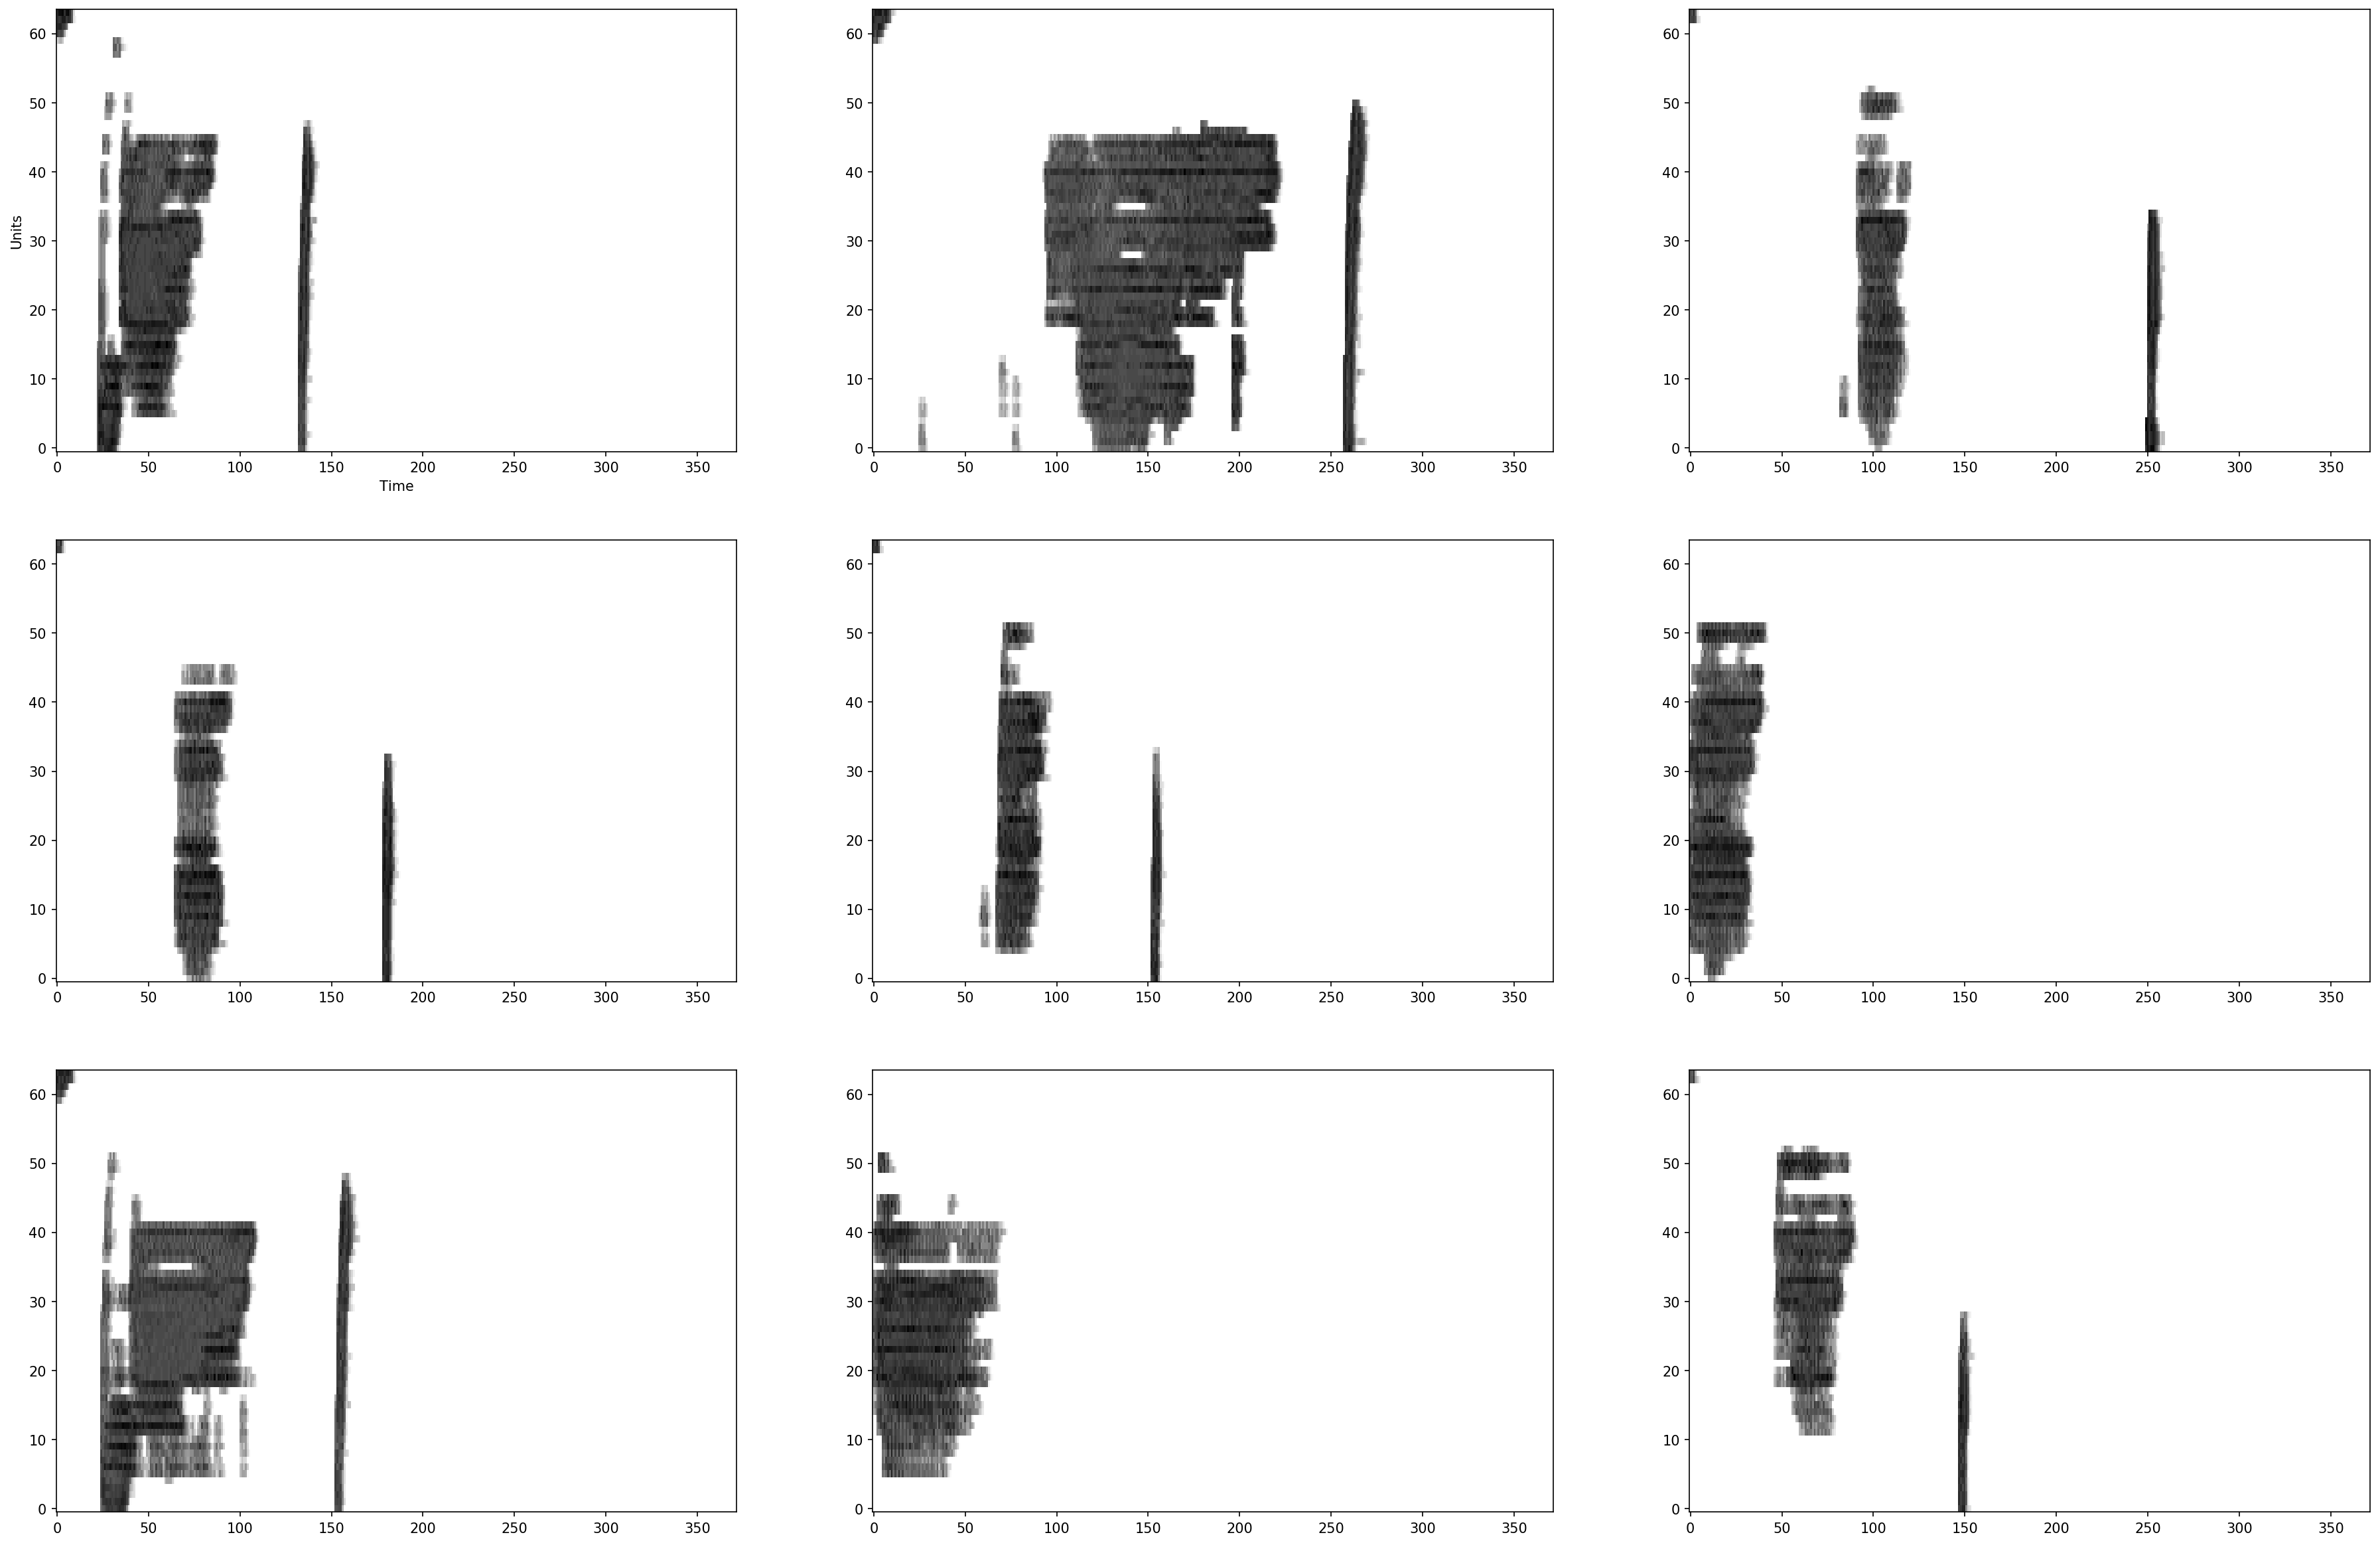

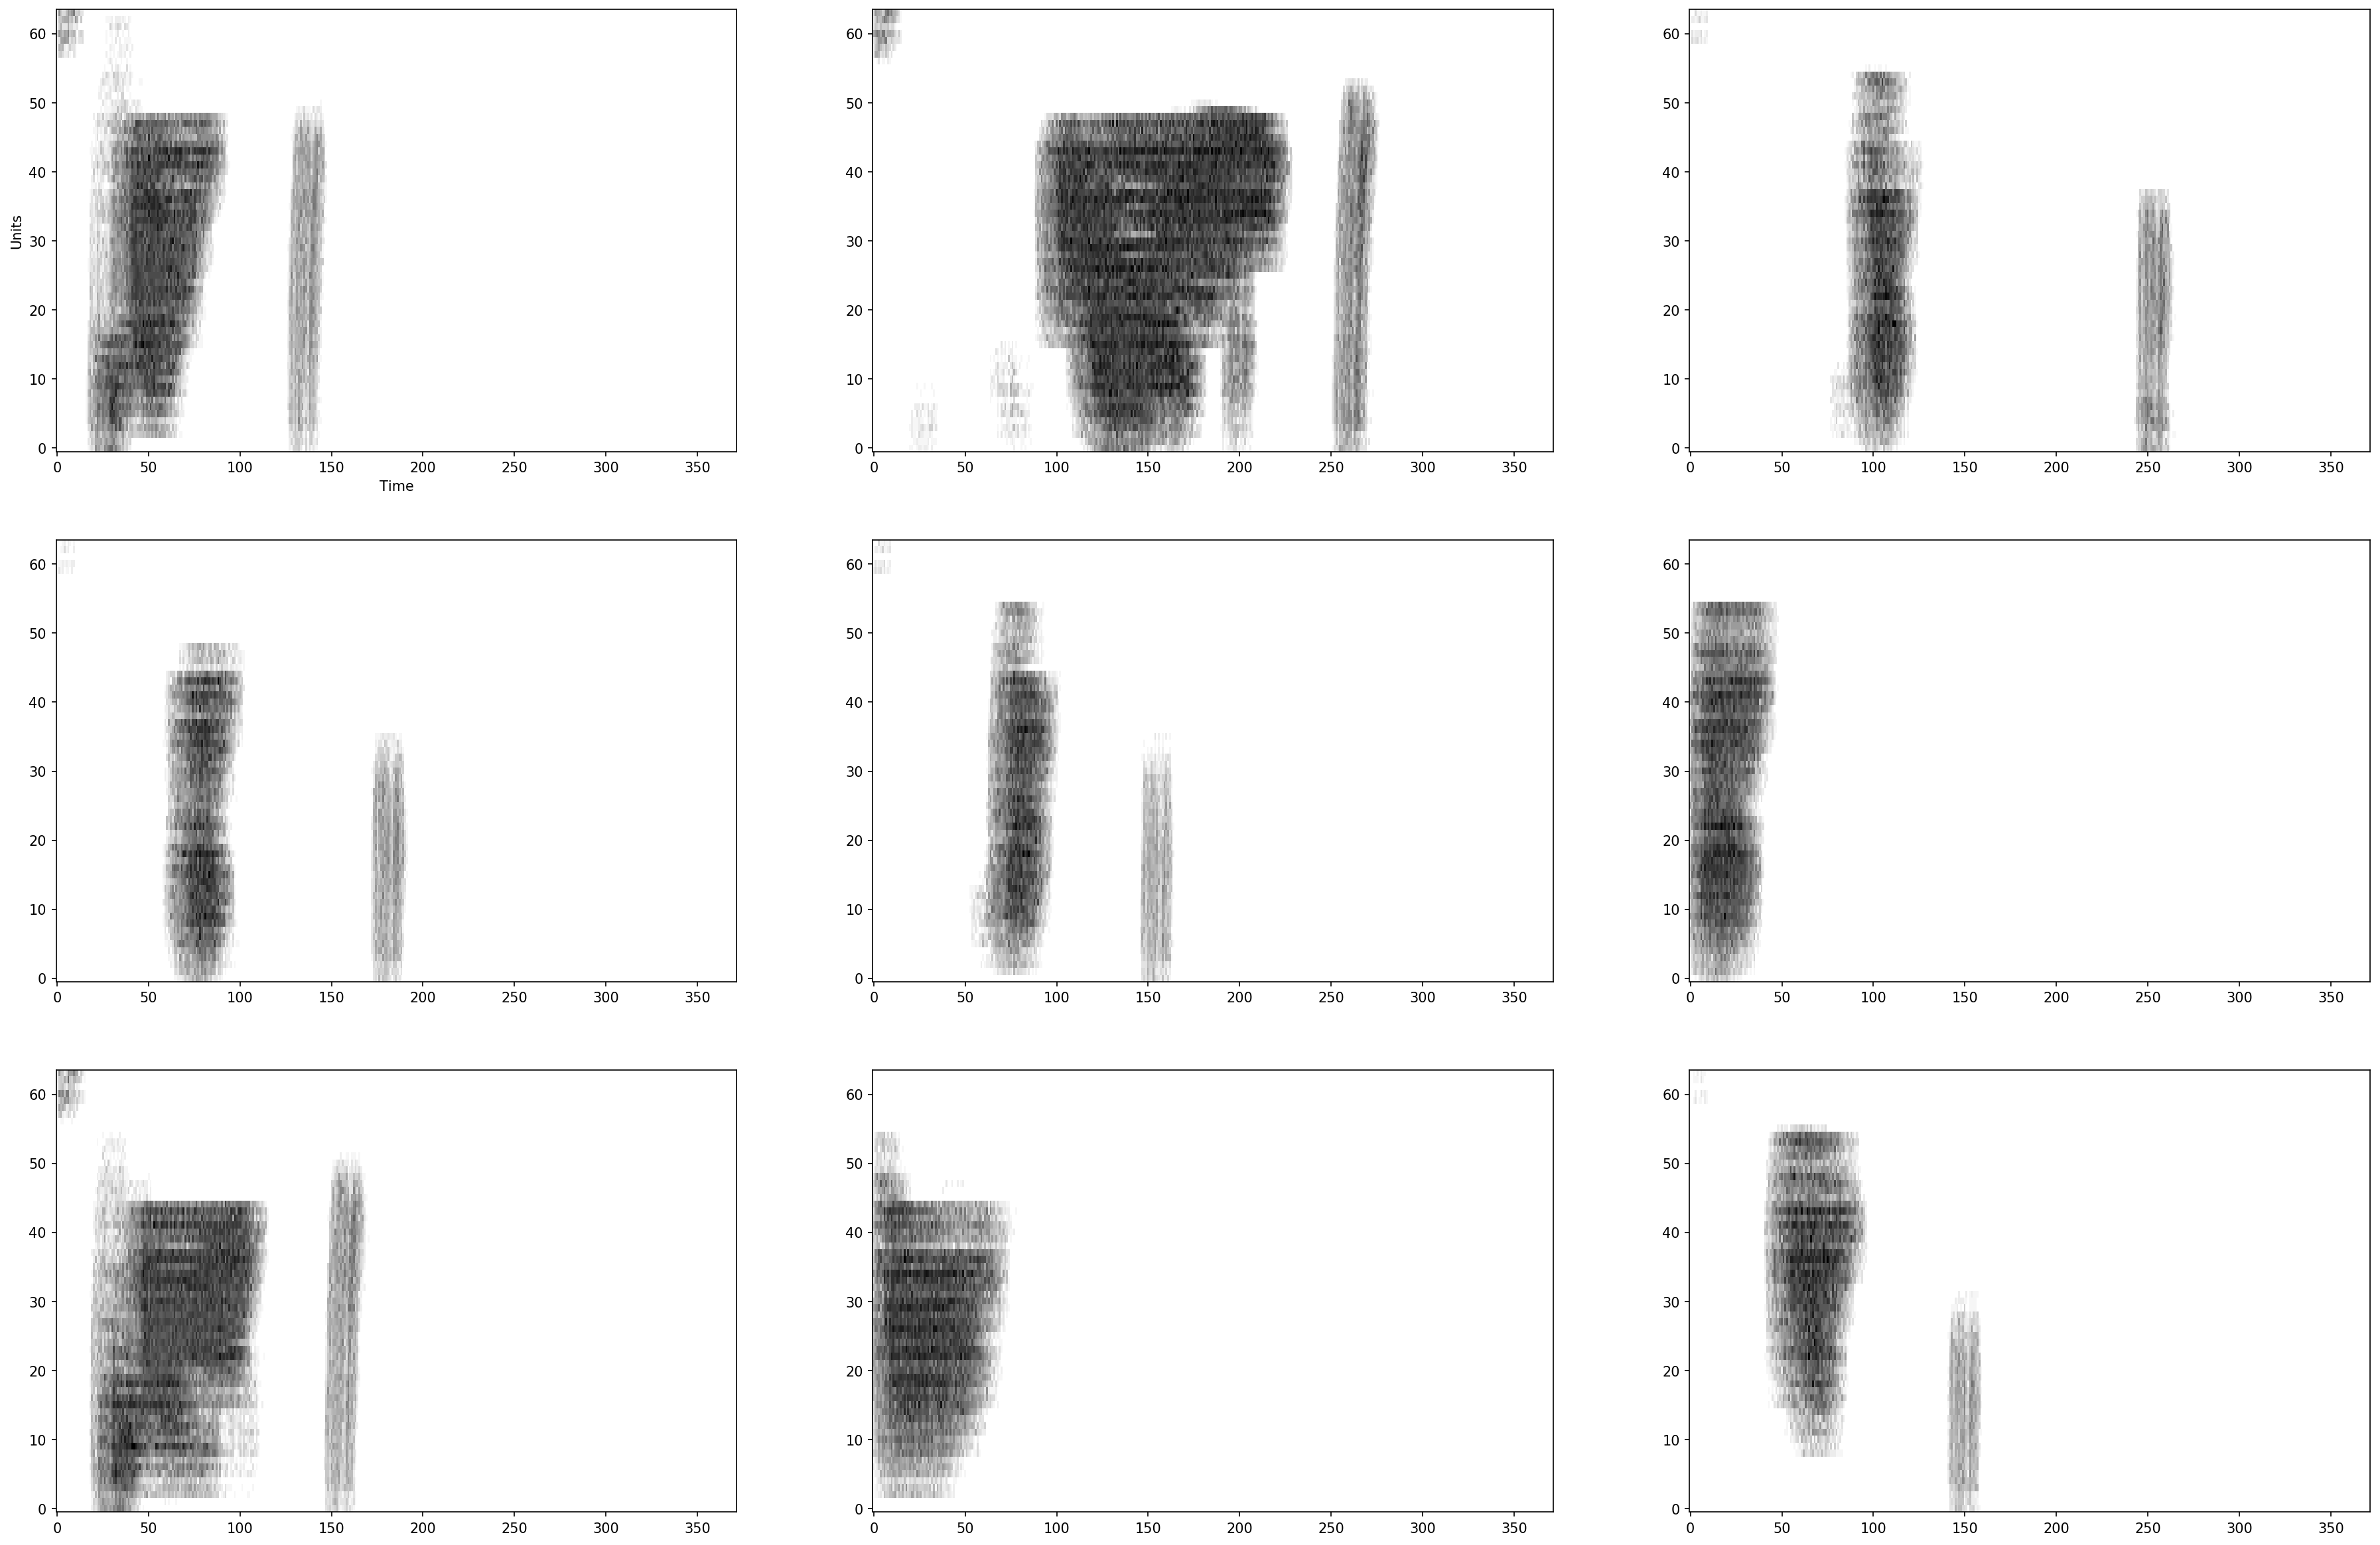

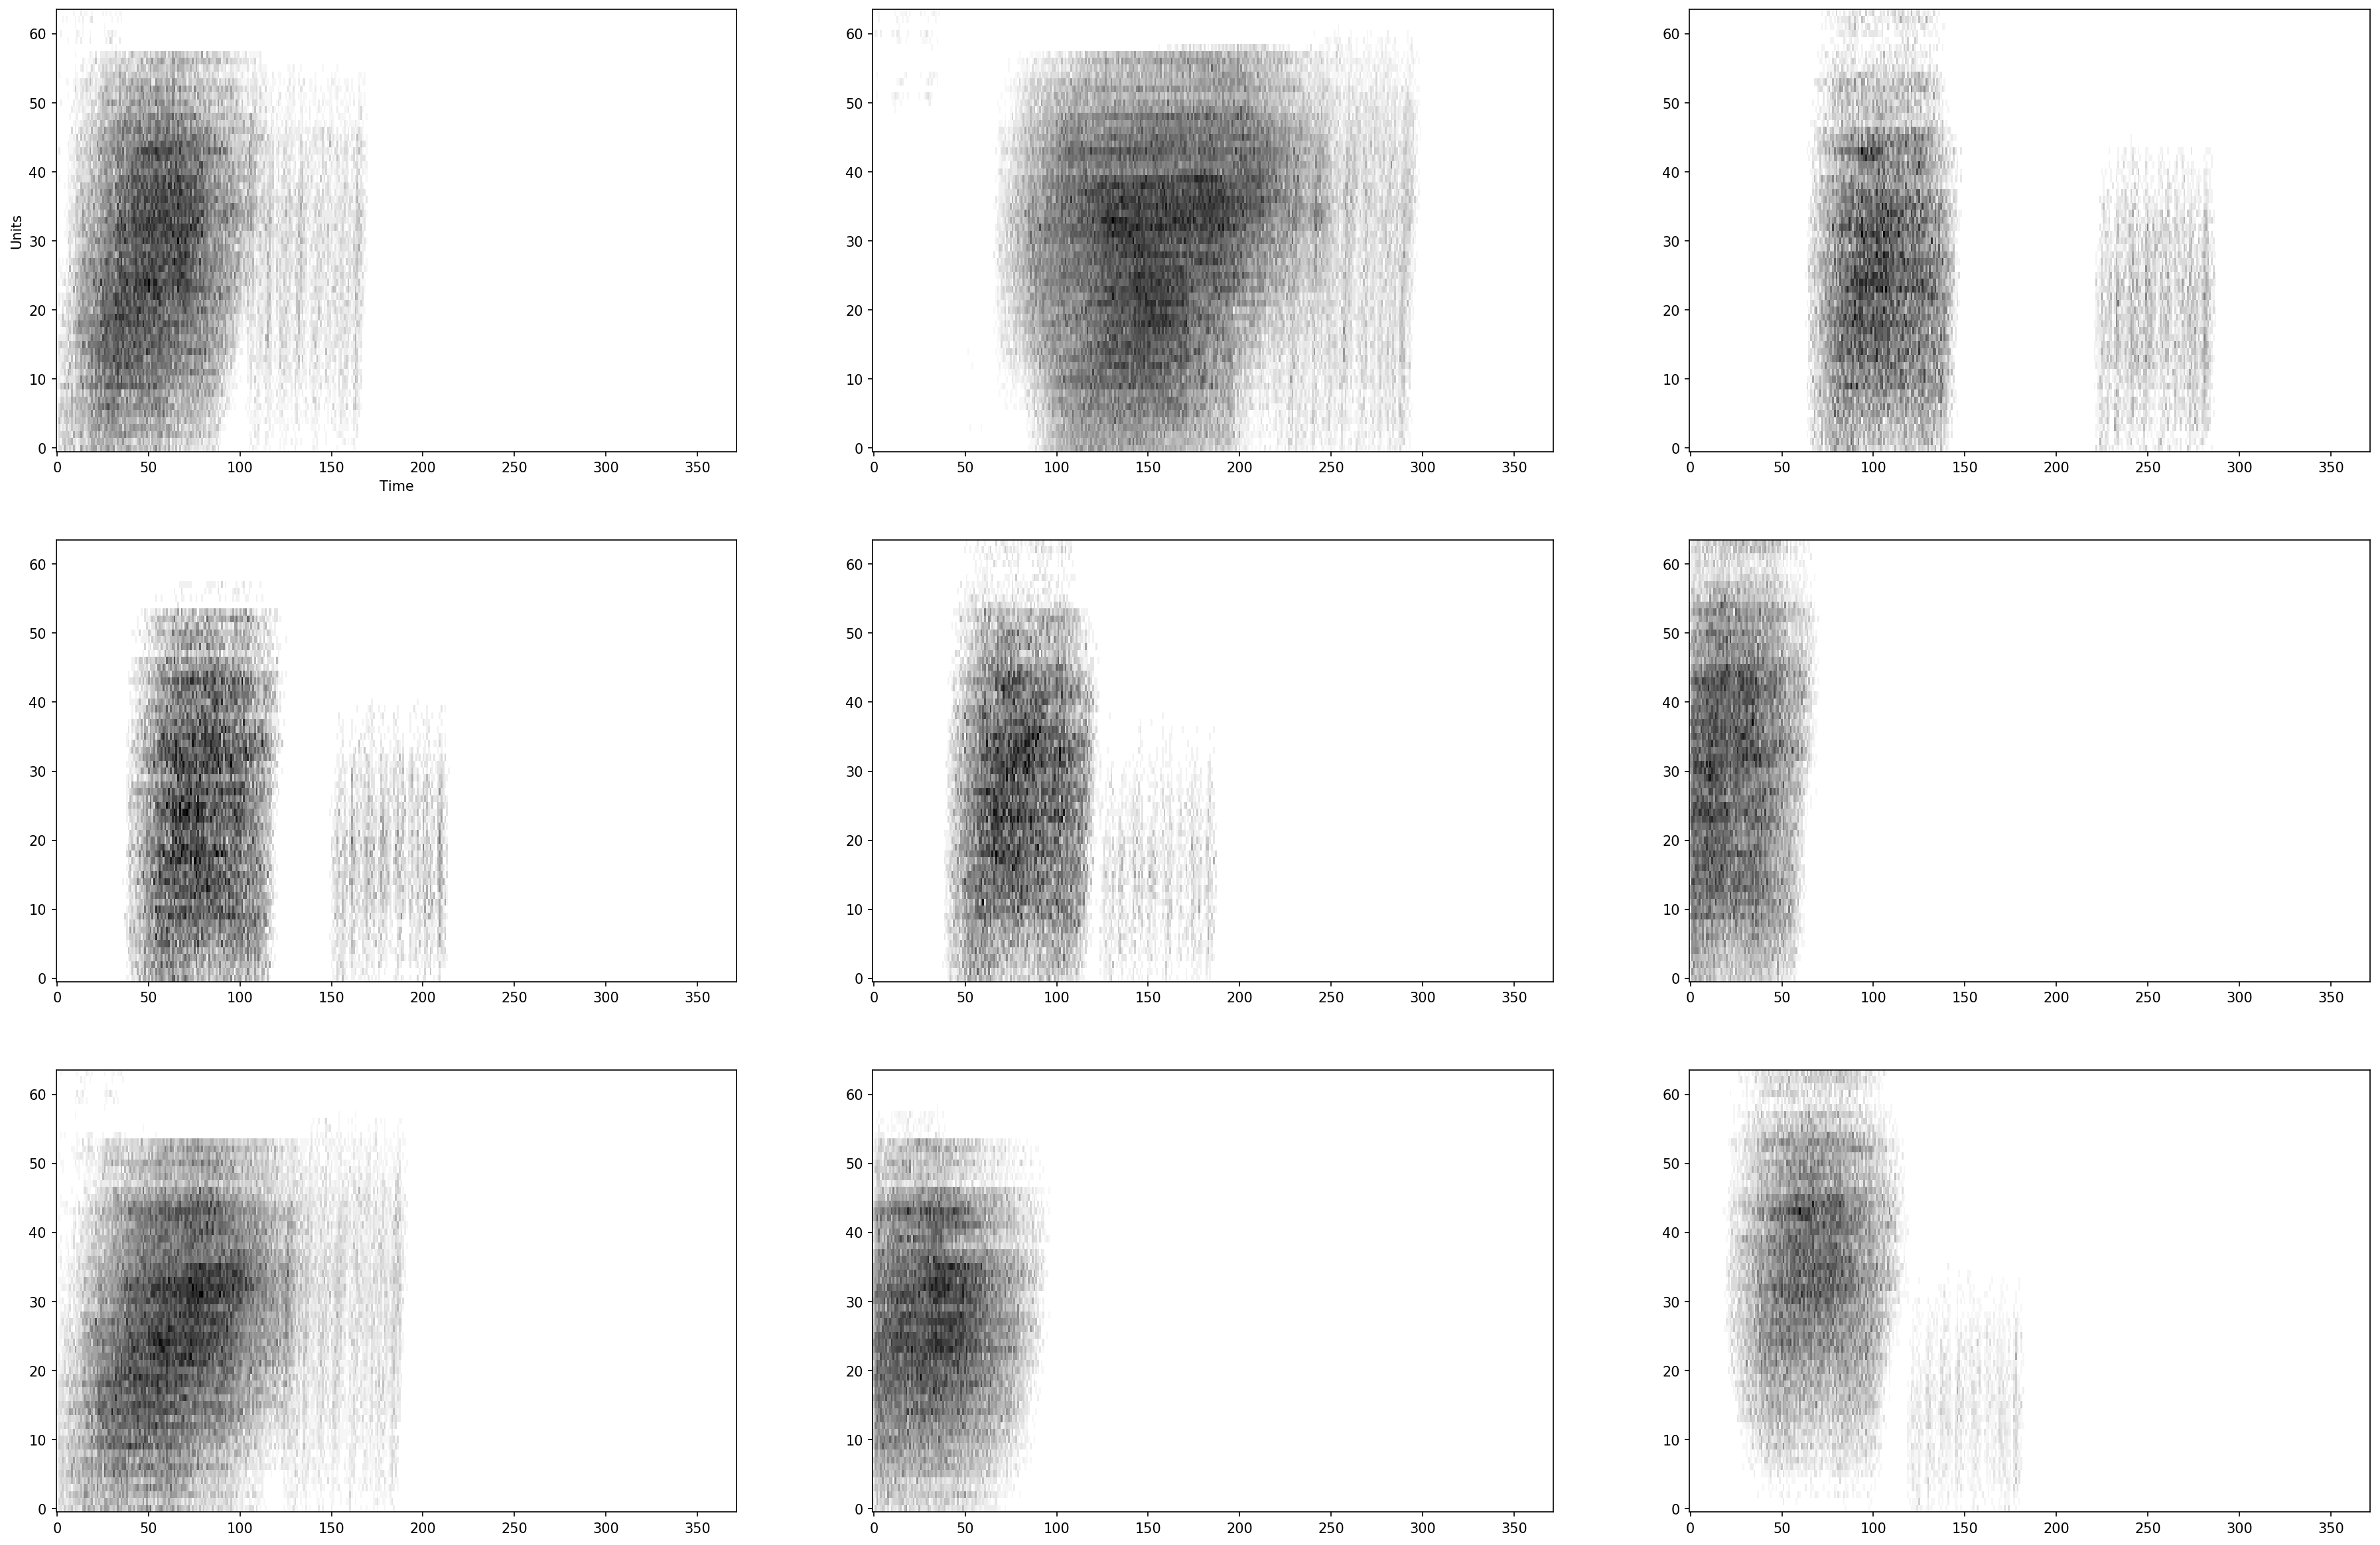

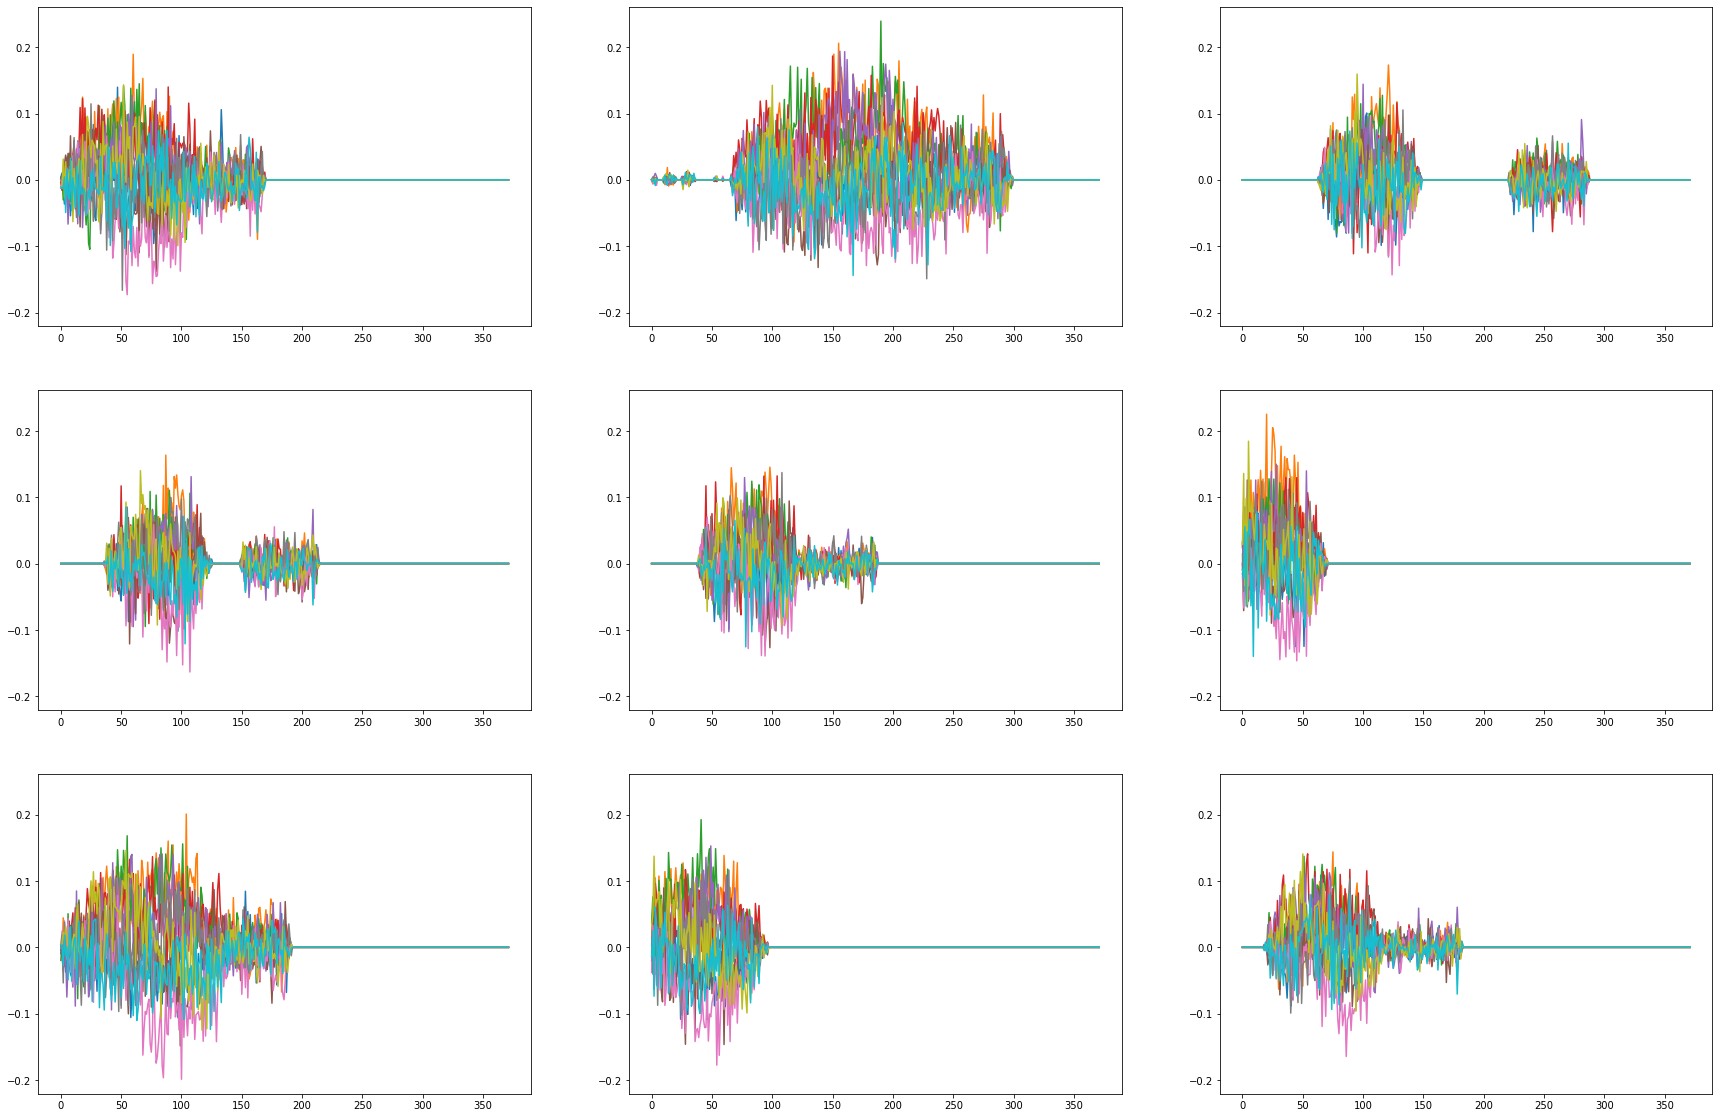

In [11]:
nb_plt = 9
batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers): 
    if isinstance(l, SpikingDenseLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

In [12]:
def train(model, params, optimizer, train_dataloader, valid_dataloader, reg_loss_coef, nb_epochs, scheduler=None, 
          warmup_epochs=0, filename=None, save_every=5, start_epoch=0, hist=None):
    
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    
    if warmup_epochs > 0:
        for g in optimizer.param_groups:
            g['lr'] /= len(train_dataloader)*warmup_epochs
        warmup_itr = 1
    
    if hist is None:
        hist = {'loss':[], 'valid_loss':[], 'valid_accuracy':[]}
    for e in tqdm(range(start_epoch, nb_epochs)):
        local_loss = []
        reg_loss = [[] for _ in range(len(model.layers)-1)]
        for x_batch, y_batch in tqdm(train_dataloader):
            x_batch = x_batch.to(device, dtype)
            x_batch = x_batch.unsqueeze(1)
            y_batch = y_batch.float().to(device)

            output, loss_seq = model(x_batch)
            log_p_y = log_softmax_fn(output)
            loss_val = loss_fn(log_p_y, y_batch.long())
            local_loss.append(loss_val.item())

            for i,loss in enumerate(loss_seq[:-1]):
                reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
                loss_val += reg_loss_val
                reg_loss[i].append(reg_loss_val.item())

            optimizer.zero_grad()
            loss_val.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            optimizer.step()
            model.clamp()

            if e < warmup_epochs:
                for g in optimizer.param_groups:
                    g['lr'] *= (warmup_itr+1)/(warmup_itr)
                warmup_itr += 1
                
                #pb.update(1)
                
        if scheduler is not None and e >= warmup_epochs:
            scheduler.step()
        
        mean_loss = np.mean(local_loss)
        hist['loss'].append(mean_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        for i,loss in enumerate(reg_loss):
            mean_reg_loss = np.mean(loss)
            print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
        for i,l in enumerate(snn.layers[:-1]):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        
        valid_accuracy, valid_loss = compute_classification_accuracy(model, valid_dataloader)
        hist['valid_accuracy'].append(valid_accuracy)
        hist['valid_loss'].append(valid_loss)
        print("Validation accuracy=%.3f"%(valid_accuracy))
        print("Validation loss=%.3f"%(valid_loss))
        
        if filename and ((e + 1) % save_every == 0):
            torch.save([model, optimizer, hist],
                       filename+'%04d.pt' % (e + 1))
            print('Epoch %5d/%5d, checkpoint saved' % (e + 1, nb_epochs))
        print("")
        
    return hist
        
def compute_classification_accuracy(model, dataloader):
    accs = []
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    local_loss = []
    with torch.no_grad():
        #with tqdm_notebook(total=len(dataloader)) as pb:
        for x_batch, y_batch in dataloader:

            x_batch = x_batch.to(device, dtype)
            x_batch = x_batch.unsqueeze(1)
            y_batch = y_batch.float().to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
                #pb.update(1)
                
            log_p_y = log_softmax_fn(output)
            loss_val = loss_fn(log_p_y, y_batch.long())
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)         
    return np.mean(accs), mean_loss

In [13]:
lr = 1e-3
weight_decay = 1e-5
reg_loss_coef = 0.1
nb_epochs = 10

params = [{'params':l.w, 'lr':lr, "weight_decay":weight_decay } for i,l in enumerate(snn.layers)]
params += [{'params':l.v, 'lr':lr, "weight_decay":weight_decay} for i,l in enumerate(snn.layers[:-1]) if l.recurrent]
params += [{'params':l.b, 'lr':lr} for i,l in enumerate(snn.layers)]
if snn.layers[-1].time_reduction == "mean":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers[:-1])]
elif snn.layers[-1].time_reduction == "max":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers)]
else:
    raise ValueError("Readout time recution should be 'max' or 'mean'")
    
optimizer = RAdam(params)
 
gamma = 0.85
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

In [14]:
# hist = train(snn, params, optimizer, train_dataloader, test_dataloader, reg_loss_coef, nb_epochs=nb_epochs,
#                   scheduler=scheduler, warmup_epochs=1)

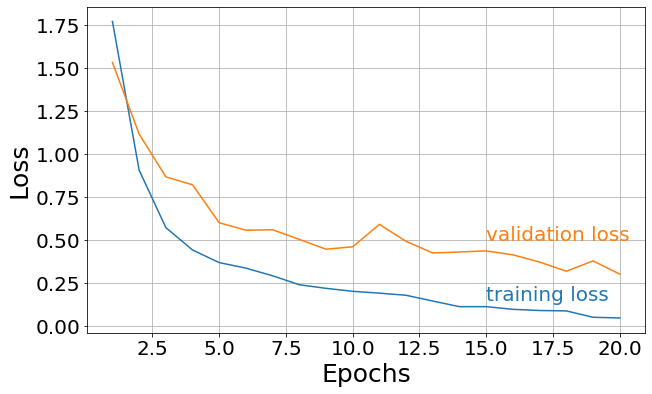

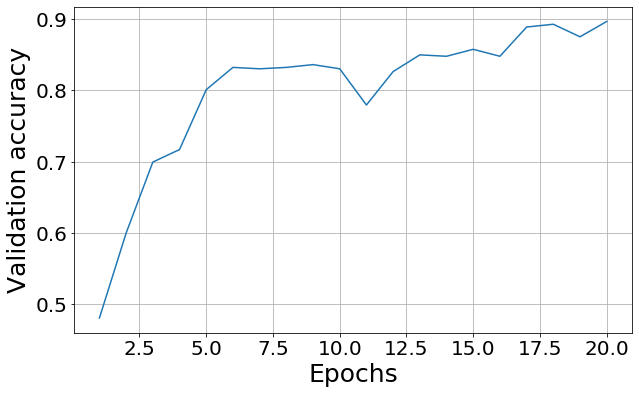

In [23]:
training = 'snn_das_time_5_0020.pt'
save_figures = True
if save_figures:
    experiment = "time_5"
    directory = os.path.join("figures", experiment)
    if not os.path.exists(directory): os.makedirs(directory)
snnet = torch.load(os.path.join('../models', training))
training_loss = snnet[2]['loss']
validation_loss = snnet[2]['valid_loss']
validation_accuracy = snnet[2]['valid_accuracy']
plt.figure(figsize=(10,6))
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.plot(np.arange(1, 1+len(training_loss)), training_loss, label='training_loss')
plt.plot(np.arange(1, 1+len(validation_loss)), validation_loss, label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.text(15, 0.15, 'training loss', c='C0', fontsize=20)
plt.text(15, 0.5, 'validation loss', c='C1', fontsize=20)
plt.grid()
# plt.legend()
if save_figures:
    filename = os.path.join(directory, "train_valid_loss")
    plt.savefig(filename, dpi=300)

plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 1+len(validation_accuracy)), validation_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.grid()
if save_figures:
    filename = os.path.join(directory, "valid_accuracy")
    plt.savefig(filename, dpi=300)
plt.show()

In [18]:
training = 'snn_das_time_5_0020.pt'
snnet = torch.load(os.path.join('../models', training))
snn = SNN(layers).to(device, dtype)
snn.load_state_dict(snnet[0].state_dict())
X_batch, _ = next(iter(train_dataloader))
X_batch = X_batch.to(device, dtype)
X_batch = X_batch.unsqueeze(1)
_ = snn(X_batch)

Layer 0: average number of spikes=0.0401
Layer 1: average number of spikes=0.0356
Layer 2: average number of spikes=0.0398


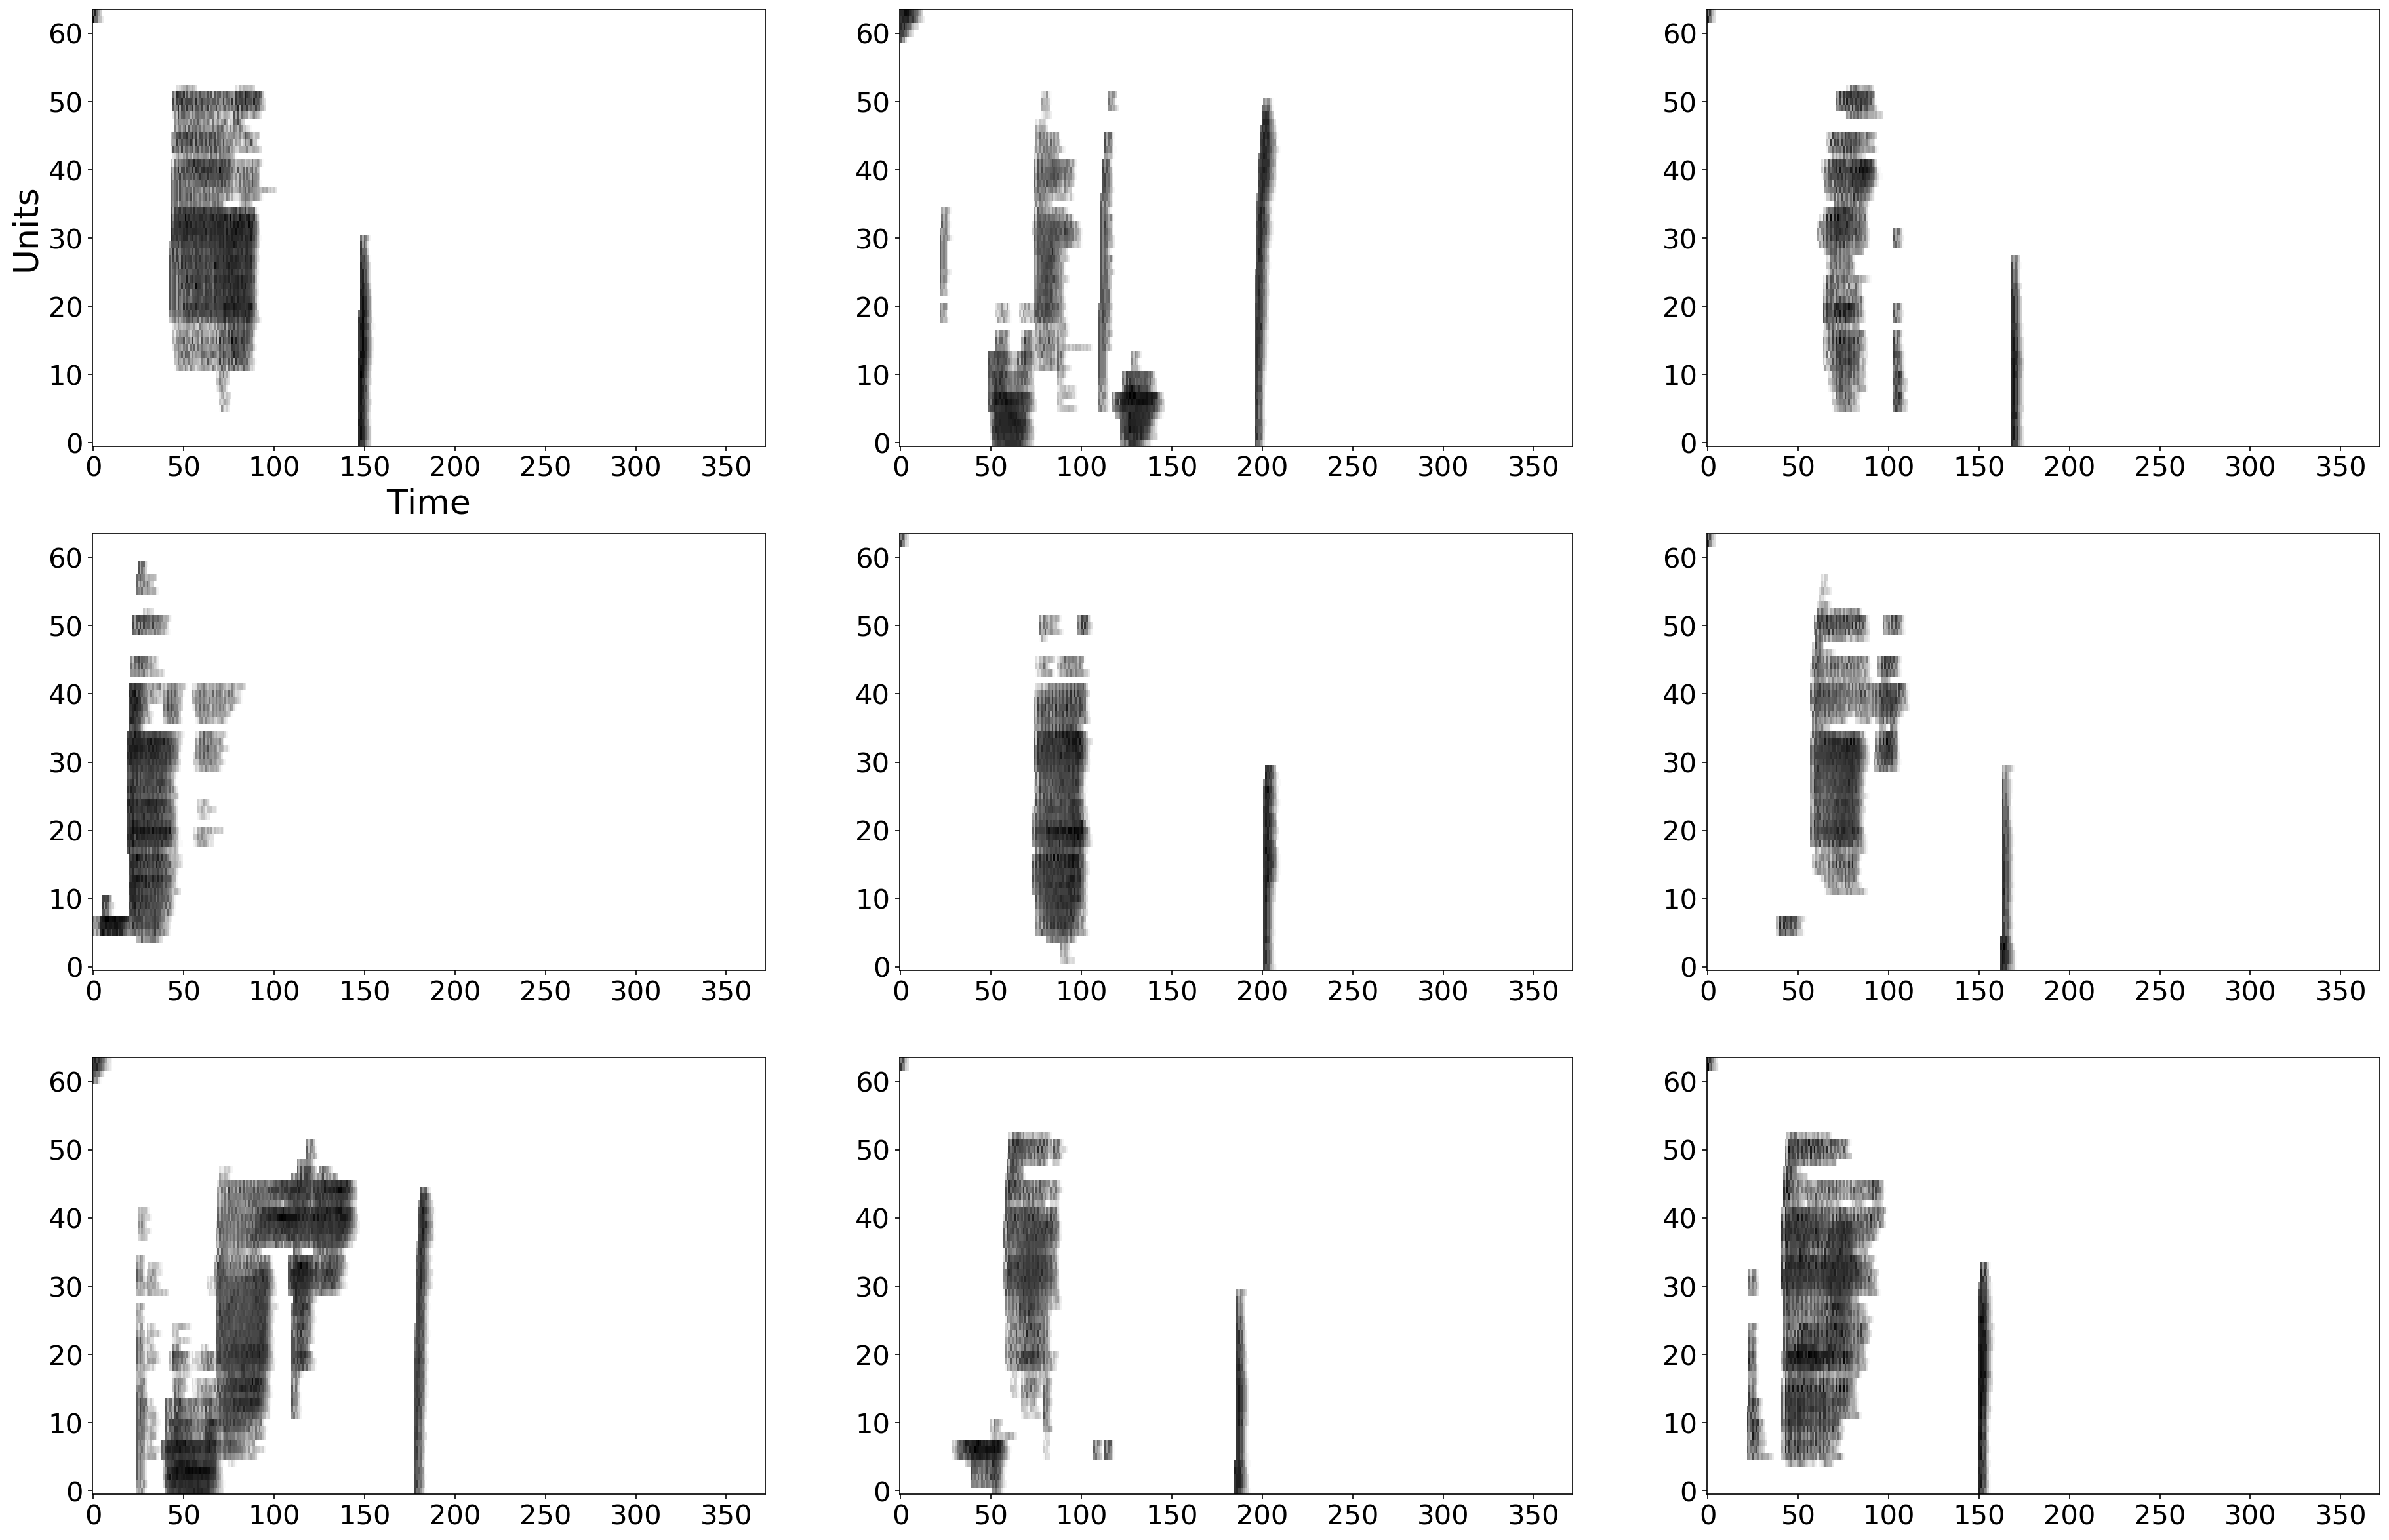

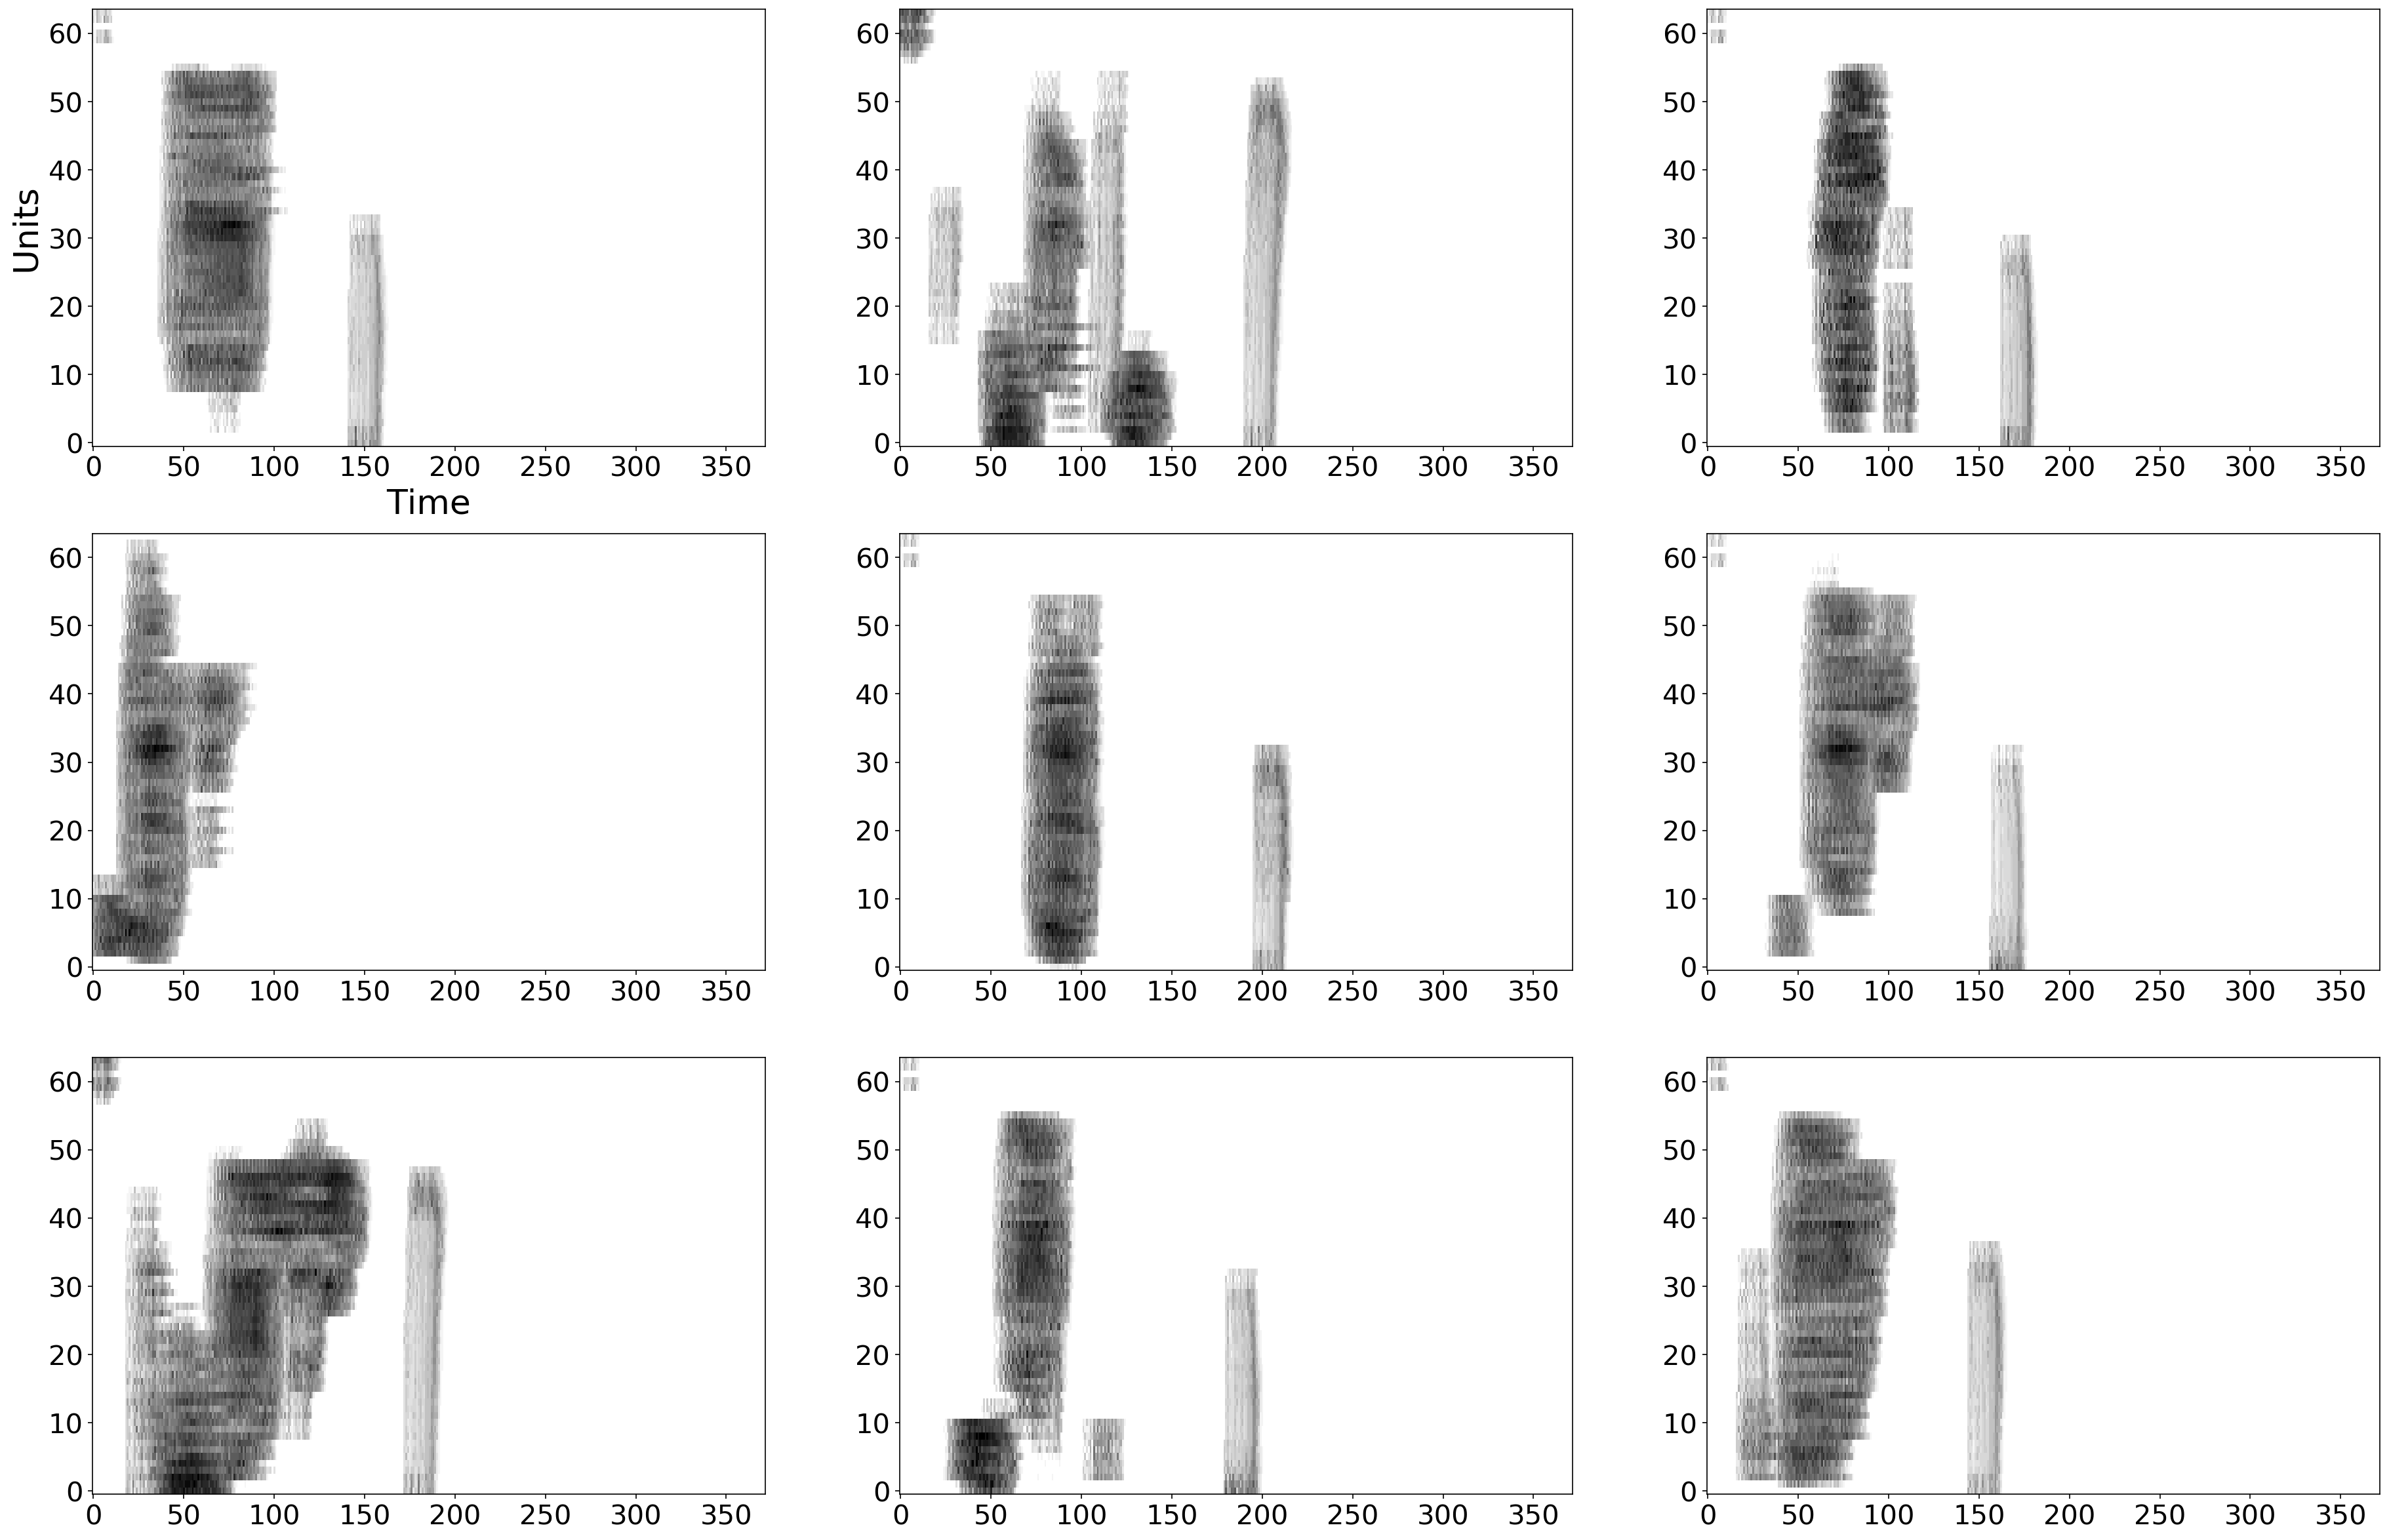

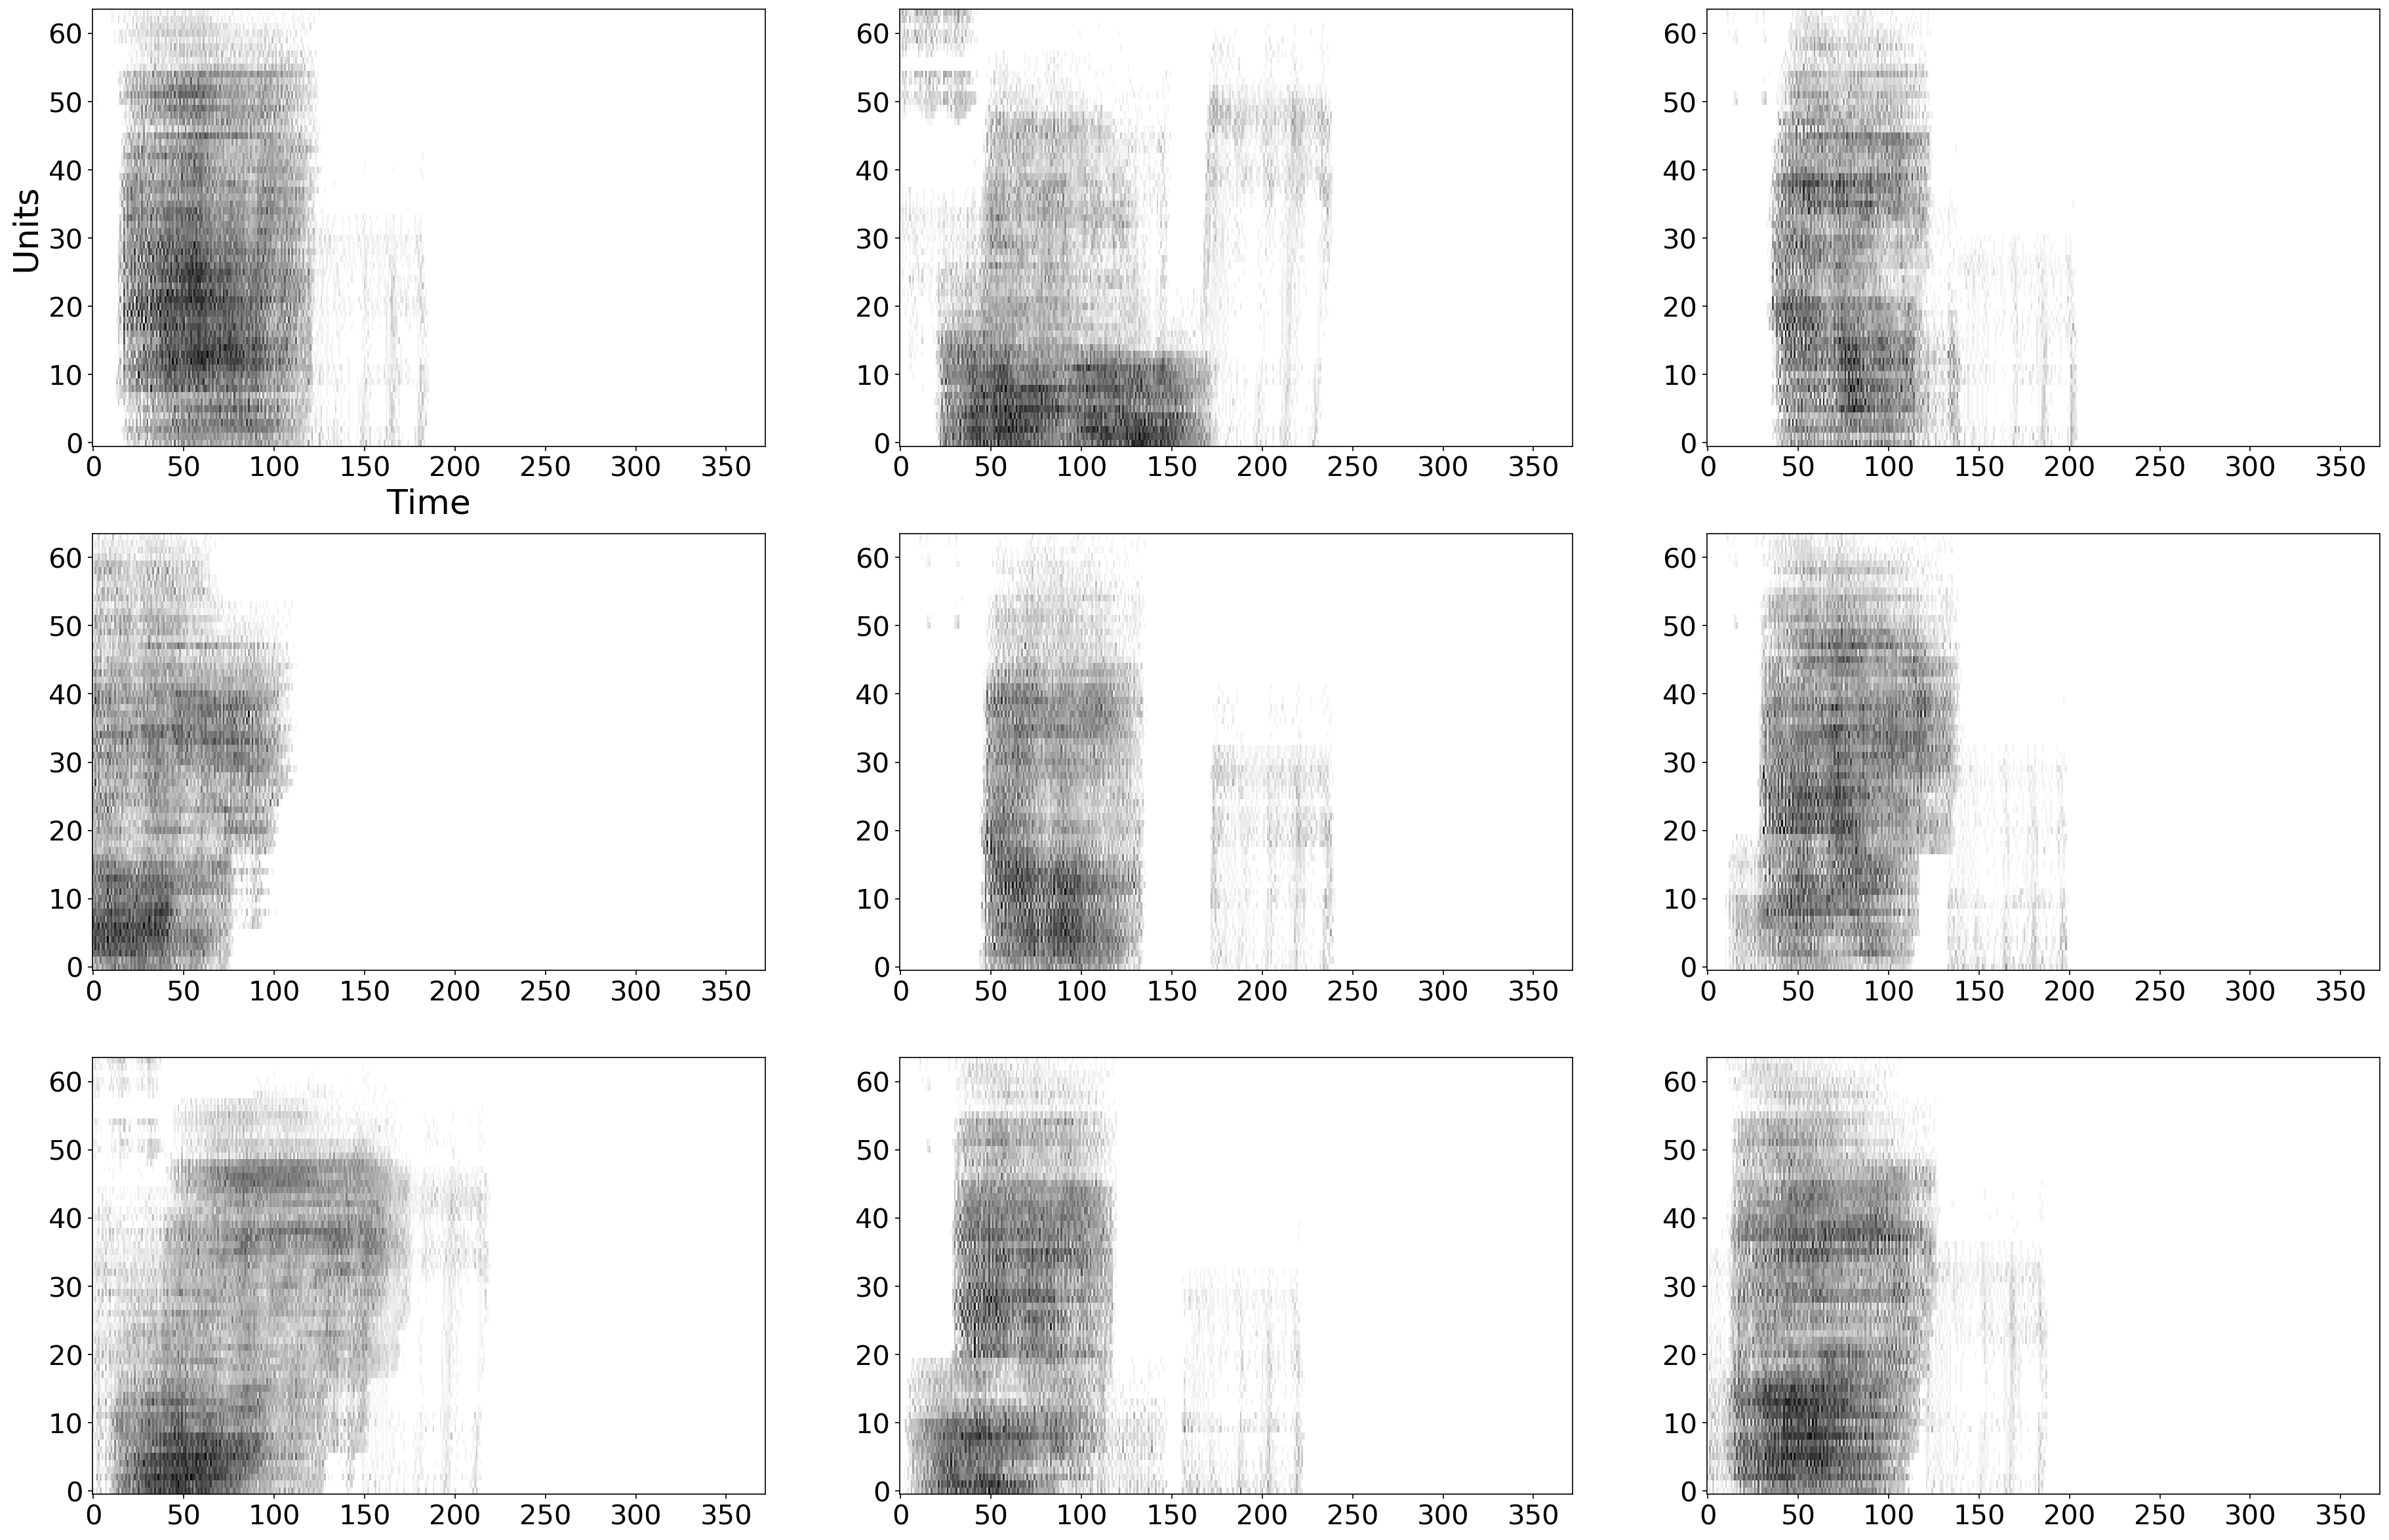

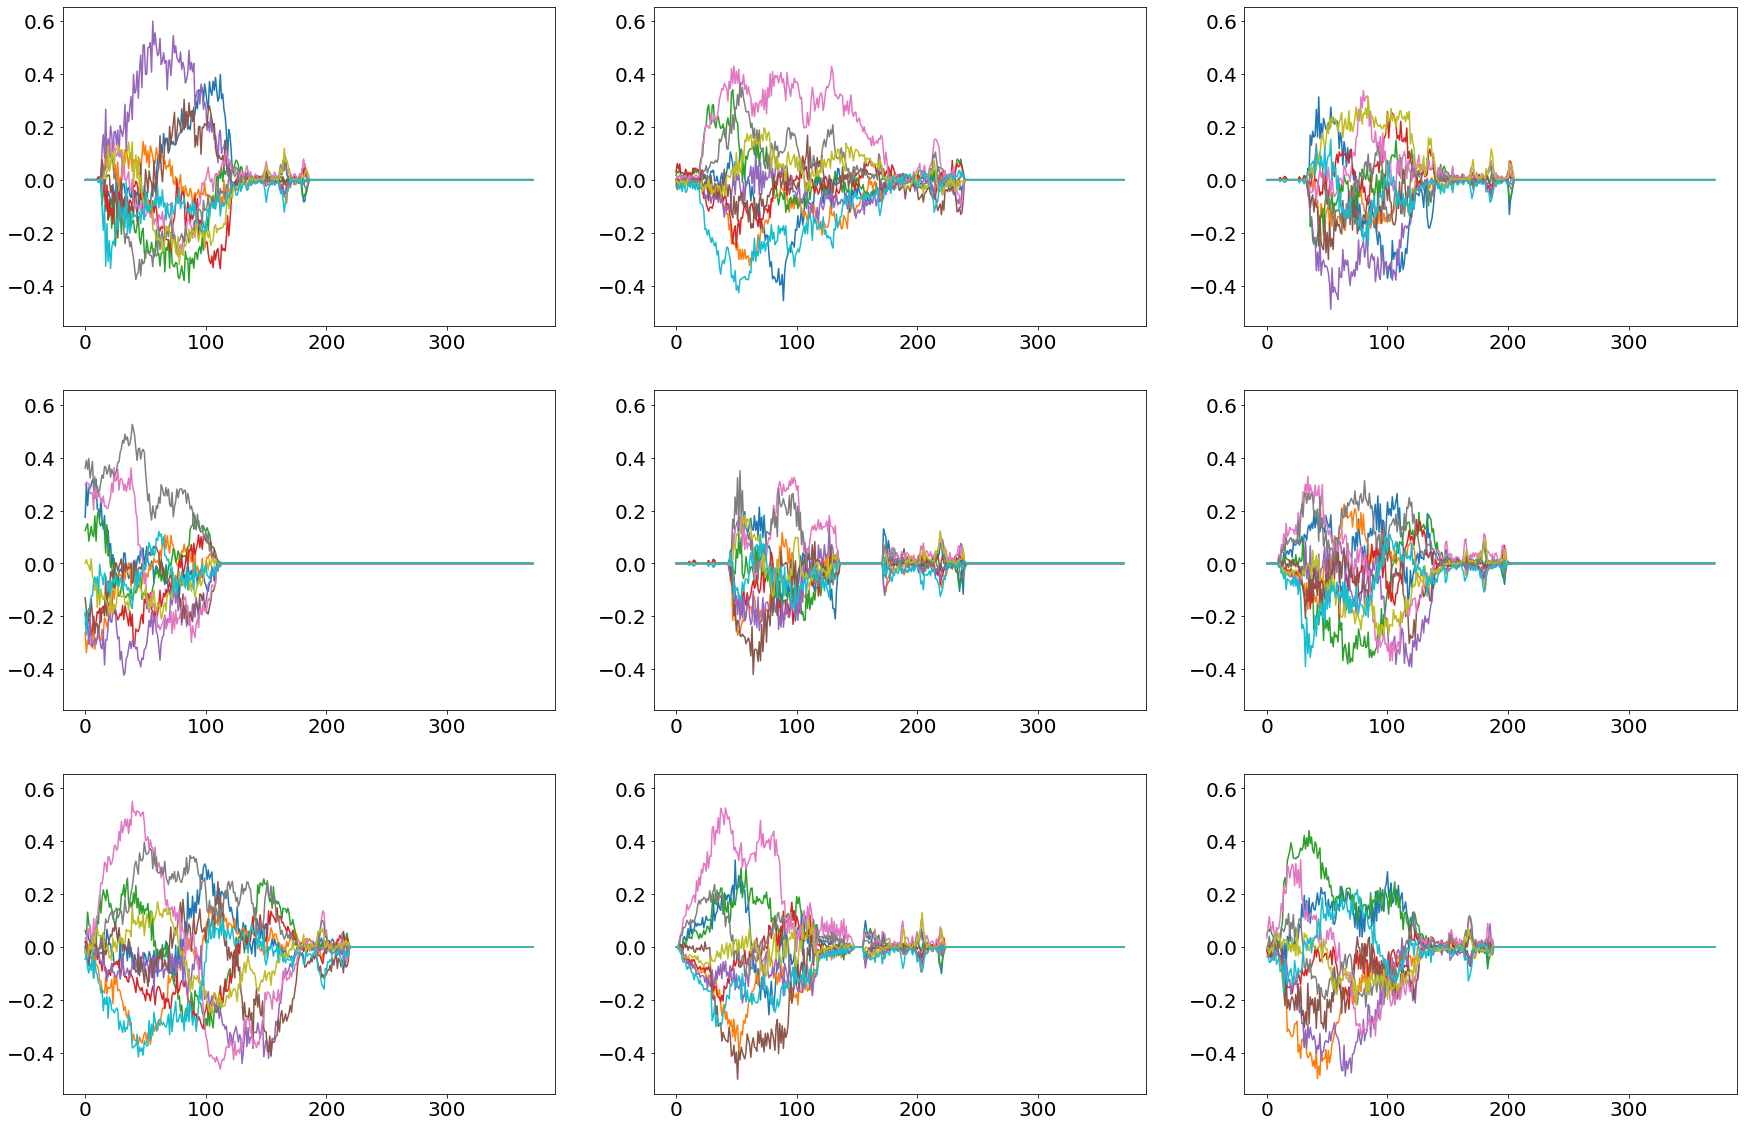

In [19]:
nb_plt = 9
batch_idx = np.random.choice(batch_size, nb_plt, replace=False)
save_figures = True
filename = None
if save_figures:
    experiment = "time_5"
    directory = os.path.join("figures", experiment)
    if not os.path.exists(directory): os.makedirs(directory)
        
for i,l in enumerate(snn.layers):
    filename = os.path.join(directory, "output_layer_" + str(i))
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx, filename=filename)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx, filename=filename)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx, filename=filename)